In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import os
from PIL import Image
import matplotlib.pyplot as plt

In [9]:
class ConvolutionalNeuralNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)  # 3: colors - R G B, 6: output layer size, 5: convolution kernel size
        self.pool = nn.MaxPool2d(4, 4)  #4: Pool size, 4: Stride size
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*17*17, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):  # n: number samples in a batch.
        # Start with n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Use local GPU for CNN models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Check the size of one image

reshaped_dir = r'../Pneumonia_classification_data/reshape_300'
image_path = r'train/NORMAL/IM-0225-0001.jpeg'
file_path = os.path.join(reshaped_dir, image_path)

img = Image.open(file_path)
print(f'Size of this image is :{img.size}')
plt.imshow(img, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: '../Pneumonia_classification_data/reshape_folder\\train/NORMAL/IM-0225-0001.jpeg'

In [9]:
# Set ML configuration
data_dir = r'../Pneumonia_classification_data/reshape_300'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 5
batch_size = 4
rate_learning = 0.001
classes = ('Normal', 'Pneumonia')

In [10]:
# Load and transform datasets
# Images are processed from main.py to 300x300 greyscale jpeg format
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')


transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor()])
dataset_test = datasets.ImageFolder(test_dir, transform=transform)
dataset_train = datasets.ImageFolder(train_dir, transform=transform)
dataset_val = datasets.ImageFolder(val_dir, transform=transform)

loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [47]:
# Setup model, loss, optimizer and total training steps
model = ConvolutionalNeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=rate_learning)
n_total_steps = len(loader_train)

In [48]:
# Start model training
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
print('Finished Training')

Epoch [1/5], Step [100/1285], Loss: 0.6437
Epoch [1/5], Step [200/1285], Loss: 0.7105
Epoch [1/5], Step [300/1285], Loss: 0.5885
Epoch [1/5], Step [400/1285], Loss: 0.5726
Epoch [1/5], Step [500/1285], Loss: 0.5588
Epoch [1/5], Step [600/1285], Loss: 0.5603
Epoch [1/5], Step [700/1285], Loss: 0.7834
Epoch [1/5], Step [800/1285], Loss: 0.3418
Epoch [1/5], Step [900/1285], Loss: 0.5750
Epoch [1/5], Step [1000/1285], Loss: 0.8185
Epoch [1/5], Step [1100/1285], Loss: 0.3046
Epoch [1/5], Step [1200/1285], Loss: 0.7938
Epoch [2/5], Step [100/1285], Loss: 0.5681
Epoch [2/5], Step [200/1285], Loss: 0.7953
Epoch [2/5], Step [300/1285], Loss: 0.5430
Epoch [2/5], Step [400/1285], Loss: 0.5712
Epoch [2/5], Step [500/1285], Loss: 0.5544
Epoch [2/5], Step [600/1285], Loss: 0.7955
Epoch [2/5], Step [700/1285], Loss: 0.2931
Epoch [2/5], Step [800/1285], Loss: 0.5302
Epoch [2/5], Step [900/1285], Loss: 0.7883
Epoch [2/5], Step [1000/1285], Loss: 0.5346
Epoch [2/5], Step [1100/1285], Loss: 0.7927
Epoch 

In [49]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    for images, labels in loader_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predictions == labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predictions[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(2):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc:.2f} %')

Accuracy of the network: 72.91666666666667 %
Accuracy of Normal: 29.49 %
Accuracy of Pneumonia: 98.97 %


In [10]:
# Show classes names and value
print(dataset_test.classes)
print(dataset_test.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


torch.Size([4, 1, 300, 300])
The answer of images are tensor([0, 1, 0, 1])


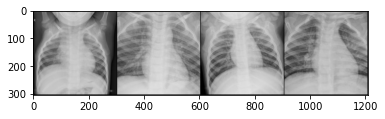

In [41]:
# Check loaded data samples
images, labels = next(iter(loader_val))
print(images.shape)

plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0))
print(f'The answer of images are {labels}')

In [42]:
# Load a batch of sample images, to verify the network connections
conv1 = nn.Conv2d(1, 6, 5)
pool = nn.MaxPool2d(4, 4)
conv2 = nn.Conv2d(6, 16, 5)
x = conv1(images)
print(f'Shape of Conv NN Layer 1 {x.shape}')
x = pool(F.relu(x))
print(f'Shape of Layer after pool {x.shape}')
x = conv2(x)
print(f'Shape of Conv NN Layer 2 {x.shape}')
x = pool(F.relu(x))
print(f'Shape of Layer after pool {x.shape}')
# x = conv3(x)
# print(f'Shape of Conv NN Layer 3 {x.shape}')
# x = pool(F.relu(x))
# print(f'Shape of Layer after pool {x.shape}')

Shape of Conv NN Layer 1 torch.Size([4, 6, 296, 296])
Shape of Layer after pool torch.Size([4, 6, 74, 74])
Shape of Conv NN Layer 2 torch.Size([4, 16, 70, 70])
Shape of Layer after pool torch.Size([4, 16, 17, 17])
